# Lab 8 Grover’s search with an unknown number of solutions

In [68]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit.library import QFT, Diagonal, GroverOperator, MCMT
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel

import numpy as np
import matplotlib.pyplot as plt

In [69]:
sim = AerSimulator()

## Part 1: Quantum Counting

### 1. Find the number of solutions of the given oracle for a search problem through quantum counting. 

#### Step A. Construct a gate for Grover iteration. 

In [70]:
# def initialize_s(qc, qubits):
#     """Apply a H-gate to 'qubits' in qc"""
#     for q in qubits:
#         qc.h(q)
#     return qc

In [71]:
def diffuser(myqc, m):
    for j in range(m):
        myqc.z(j)
        myqc.h(j)
    
    # apply multiply controlled-Z, which gives a phase to the all |1> state
    myqc.h(m-1)
    myqc.mcx(list(range(m-1)),m-1)
    myqc.h(m-1)
      
    # transform |1> to |+>
    for j in range(m):
        myqc.h(j)
        myqc.z(j)
        
    # get global phase of -1 (there must be a better way!)
    myqc.z(0)
    myqc.x(0)
    myqc.z(0)
    myqc.x(0)
    
    Diffuser = myqc.to_gate()
    return Diffuser

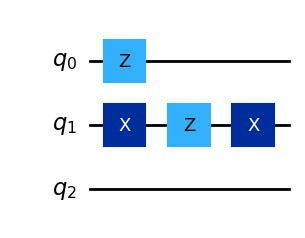

In [72]:
## Create an Oracle

N = 8 # the number of total items in the search space
m = int(np.log2(N)) # the number of qubits required to construct the search space with N items

myqc = QuantumCircuit(m, name='Oracle')
myqc.x(1)
myqc.z(range(2))
myqc.x(1)
Oracle = myqc.to_gate()
myqc.draw(output='mpl')

In [73]:
hads = QuantumCircuit(m)
hads.h(range(m))
ket = Statevector(hads.compose(myqc))
ket.to_dict()

{'000': (-0.3535533905932737+0j),
 '001': (0.3535533905932737+0j),
 '010': (0.3535533905932737+0j),
 '011': (-0.3535533905932737+0j),
 '100': (-0.3535533905932737+0j),
 '101': (0.3535533905932737+0j),
 '110': (0.3535533905932737+0j),
 '111': (-0.3535533905932737+0j)}

&#128211; Complete the circuit, `qc`, to create Grover iteration gate/operator, `Grover`, by adding the diffuser, explained as the step 3 in the first section `1.Introdcution` of [Ch.3.10 Grover's Algorithm](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb).

In [74]:
qc = QuantumCircuit(m)
qc.append(Oracle, range(m))

### solution here
myqc = QuantumCircuit(m, name='Diffuser')

# transform |+> to |1>
Diffuser = diffuser(myqc, m)
qc.append(Diffuser, range(m))
####

Grover = qc.to_gate()

#### &#128211;Step B. Build a quantum circuit, <code>circ</code>, for quantum counting employing the IPE algorithm to find the eigenvalue of the Grover iterator, <code>Grover</code> that we made in Step A. 

In [75]:
###### solution here

# and a contolled version of the Grover iterator
def cGrover(k, Grover, m):
    
    # make gate for 2^k repetitions of grover
    qc = QuantumCircuit(m)
    for _ in range(2**k):
        qc.append(Grover, range(m))
    grover_k = qc.to_gate()
    grover_k.name = 'Grover_[2^'+str(k)+']'
    
    # make and return controlled version of this gate
    cGrover_k = grover_k.control()
    return cGrover_k 

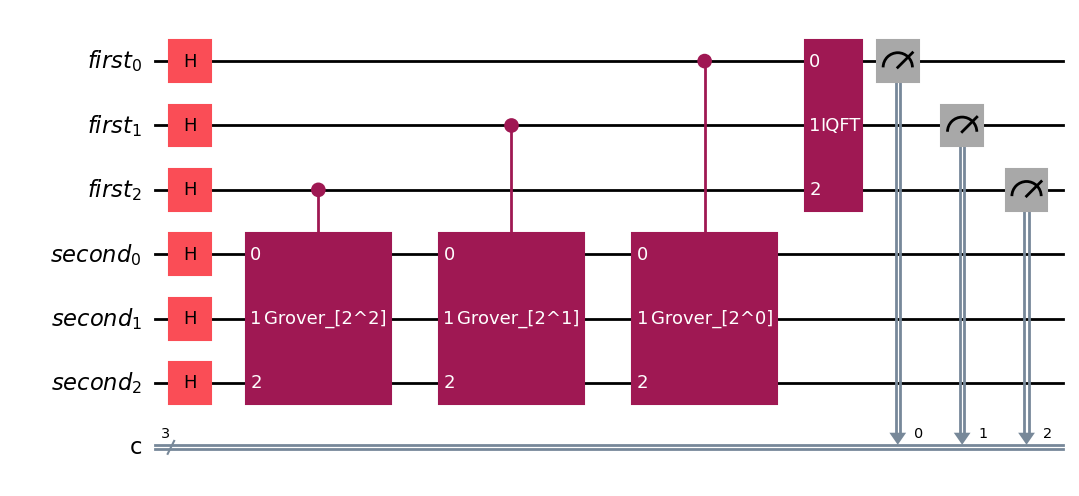

In [76]:
# number of bits required for the answer
t = 3

# we'll need the inverse QFT
qft = QFT(t)
inv_qft = qft.inverse()

# the first and second quantum registers, as in the lecture
first = QuantumRegister(t,'first')
second = QuantumRegister(m,'second')

# output for the second register
output = ClassicalRegister(t, name="c")

# now make the circuit
circ = QuantumCircuit(first, second, output)

# the first register is initialized as the all |+> state
circ.h(first)

# we'll prepare the |s> state for the qubits of the second register
circ.h(second)

# apply the controlled Grover ops
for k in range(t):    
    circ.append(cGrover(t-k-1, Grover, m), [first[t-k-1]]+[q for q in second] )
            
# do an inverse qft
circ.append(inv_qft, first)
        
# measure
circ.measure(first, output)
    

###################    
circ.draw('mpl')

#### &#128211;Step C. Execute the circuit that you built in Step B and find the number of solutions, $M$, from the estimated phase. 

In [77]:
def key_convert(count):
    phi_est = np.array([round(int(key, 2)/2**t, t) for key in list(count.keys())])
    key_new = list(map(str, phi_est))
    count_new = dict(zip(key_new, count.values()))
    return count_new

Results with bit strings {'110': 10026, '010': 9974}

Results with phases {'0.75': 10026, '0.25': 9974}


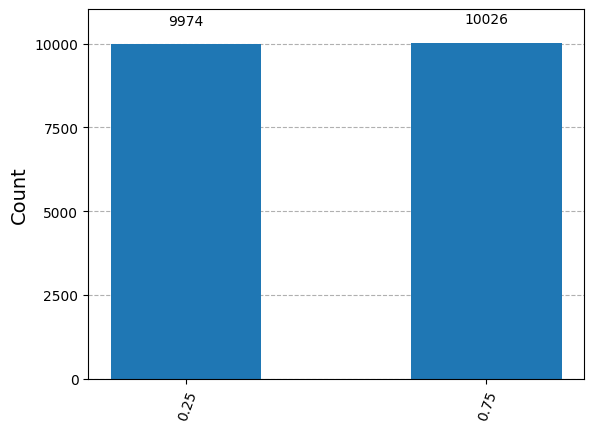

In [78]:
shots = 20000
####### solution here
compiled_circ = transpile(circ, sim)
count_circ = sim.run(compiled_circ, shots=shots).result().get_counts()
print('Results with bit strings',count_circ)

count_new = key_convert(count_circ)
print('\nResults with phases',count_new)

plot_histogram(count_new)

In [79]:
def get_solutions(count_new, N):
    errors = 0
    
    for phi in count_new:
        
        theta = float(phi)*np.pi
        
        if count_new[phi]>shots/10: # ignore spurious solutions
    
            M = np.rint(N * np.sin(theta)**2)
        
            print('Phase',phi,'implies',M,'solutions for the given oracle.')
            
        else:
            errors += count_new[phi]
            
    print('\nSpurious solutions occurred for',errors,'out of',shots,'shots.')
    return M

_ = get_solutions(count_new, N)

Phase 0.75 implies 4.0 solutions for the given oracle.
Phase 0.25 implies 4.0 solutions for the given oracle.

Spurious solutions occurred for 0 out of 20000 shots.


## Part 2: Implementing Grover's algorithem with an augmented Oracle

#### &#128211;Step A. Verify that the angle $\theta$ gets smaller as $M$ varies from $N/2$ to $N$. 

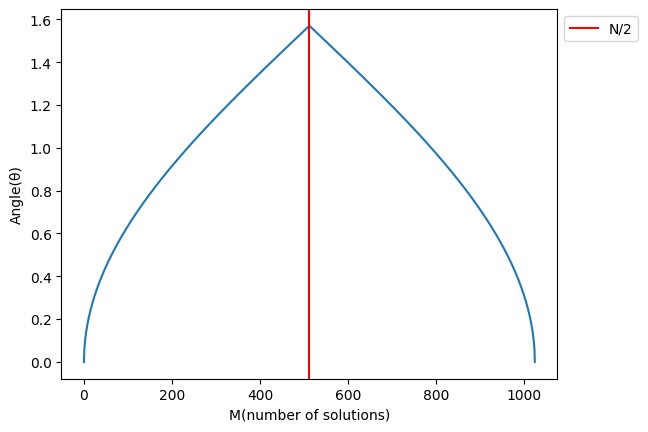

In [80]:
## Your code goes here
def get_plot(N):
    M = np.linspace(0, N, num=N)
    plt.plot(M, np.arcsin((2*np.sqrt(M*(N-M)))/N))
    plt.ylabel("Angle(θ)")
    plt.xlabel("M(number of solutions)")
    plt.axvline(x = N/2, color = 'r', label ='N/2')
    plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    return plt.show()
get_plot(2**10)

#### &#128211;Step B. Obtain the angle $\theta$ and the number of the Grover iterations, $R$, needed to find the solutions of the oracle in Part 1 and interprete the result.

In [81]:
class Find_grover_params():
    '''
        M : number of solutions
        N : the search space
    '''
    def __init__(self, M, N):
        self.M = M
        self.N = N
    def theta(self):
        angle = np.arcsin((2*np.sqrt(self.M*(self.N-self.M)))/self.N)
        return angle
    def CI_R(self, theta):
        R = np.arccos(np.sqrt(self.M/self.N))/theta
        return np.rint(R)

In [82]:
# N = 8
# M = 4
# values taken directly from PART 1
## Your code goes here

find_params = Find_grover_params(4,8)
theta = find_params.theta()
print("Theta (θ): ",theta)
print("Number of the Grover iterations (R): ", find_params.CI_R(theta)) 

Theta (θ):  1.5707963267948966
Number of the Grover iterations (R):  0.0


Since M = 4 and N = 8 which means M>=N/2 hence no need to iterate grover to get solution.

###  2. Find the solutions to the search problem from Part 1. 

#### &#128211;Step A. Build a new augmented oracle gate/operator, <code>Oracle_new</code>, in the doubled search space.

In [83]:
## your code goes here

N = 8 # same as part 1
m_ = int(np.log2(N)+1) # number of qubits
myqc_ = QuantumCircuit(m_, name='Oracle_new')
# double the search space
new_no_solution_states=[1]*N
oracle = Diagonal([-1,1,1,-1,-1,1,1,-1]+new_no_solution_states)

In [84]:
def grover_operator(n_iterations, oracle):
    grover_it = GroverOperator(oracle).repeat(n_iterations).to_gate()
    grover_it.label = f"Grover$^{n_iterations}$"
    return grover_it

In [85]:
oracle_ = oracle.to_gate()
myqc_.append(oracle_, range(m_))
# Oracle_new = myqc_.to_gate()
# myqc_.draw(output='mpl')
hads_ = QuantumCircuit(m_)
hads_.h(range(m_))
ket_ = Statevector(hads_.compose(myqc_))
ket_.to_dict()

{'0000': (-0.25+0j),
 '0001': (0.25+0j),
 '0010': (0.25+0j),
 '0011': (-0.25+0j),
 '0100': (-0.25+0j),
 '0101': (0.25+0j),
 '0110': (0.25+0j),
 '0111': (-0.25+0j),
 '1000': (0.25+0j),
 '1001': (0.25+0j),
 '1010': (0.25+0j),
 '1011': (0.25+0j),
 '1100': (0.25+0j),
 '1101': (0.25+0j),
 '1110': (0.25+0j),
 '1111': (0.25+0j)}

#### &#128211;Step B. Evaluate the number of Grover iterations, $R$, needed to find $M$ solutions among the total 16 items.

In [86]:
find_params_new = Find_grover_params(M=4, N=16)
theta_new = find_params_new.theta()
print("Theta (θ): ",theta_new)
print("Number of the Grover iterations (R): ", find_params_new.CI_R(theta_new)) 

Theta (θ):  1.0471975511965976
Number of the Grover iterations (R):  1.0


#### &#128211;Step C. Create a quantum circuit <code>qc_final</code> to find solutions to the search problem applying Grover iteration <code>R</code> times.

In [87]:
qft_dagger = QFT(4, inverse=True).to_gate()
qft_dagger.label = "QFT†"

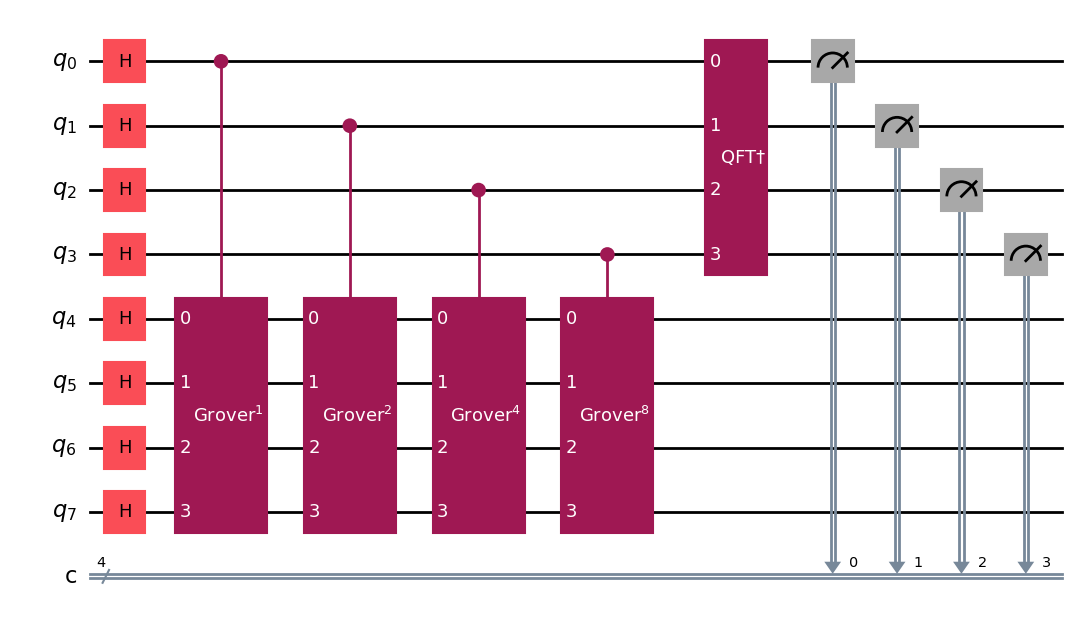

In [88]:
# Create QuantumCircuit
t = m_   # no. of counting qubits
n = m_  # no. of searching qubits
qc_final = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    qc_final.h(qubit)

# Begin controlled Grover iterations
n_iterations = 1
for qubit in range(t):
    cgrit = grover_operator(n_iterations, oracle).control()
    qc_final.append(cgrit, [qubit] + list(range(t, n+t)))
    n_iterations *= 2
    
# Do inverse QFT on counting qubits
qc_final.append(qft_dagger, range(t))

# Measure counting qubits
qc_final.measure(range(t), range(t))

# Display the circuit
qc_final.draw("mpl")

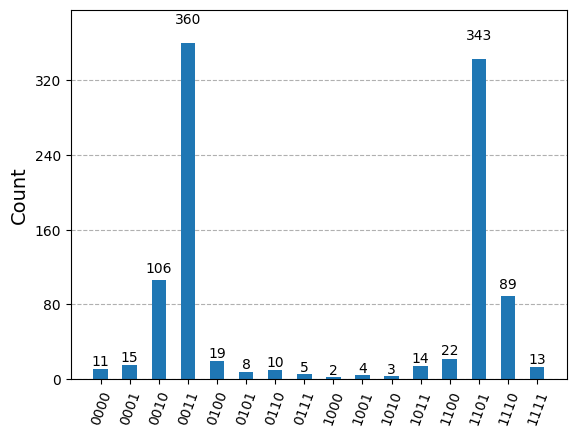

In [89]:
transpiled_qc = transpile(qc_final, sim)
job = sim.run(transpiled_qc)
hist = job.result().get_counts()
plot_histogram(hist)

In [90]:
measured_str = max(hist, key=hist.get)

In [91]:
measured_int = int(measured_str, 2)
print("Register Output = %i" % measured_int)

Register Output = 3


In [92]:
theta = (measured_int/(2**t))*np.pi*2
print("Theta = %.5f" % theta)

Theta = 1.17810


In [93]:
N = 2**n
M = np.floor(N * (np.sin(theta/2)**2))
print(f"No. of Solutions = {M:.1f}")

No. of Solutions = 4.0


#### &#128211;Step D. Check if the solutions are correct using the original oracle, <code>Oracle</code>, in Part 1.

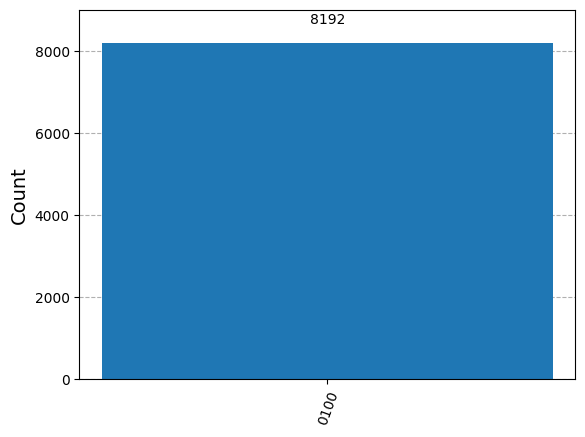

In [111]:
## your code goes here

qc_verify = QuantumCircuit(m_, m_)  # Create a new circuit for verification with m qubits and m classical bits

# Initialize the state that was found to be a solution by the augmented oracle
qc_verify.initialize(Statevector.from_int(int(list(hist.keys())[0], 2), 2**4), range(4))

# Apply the original Oracle (from Part 1)
qc_verify.append(Oracle, range(m))

# Measure the qubits to verify the result
qc_verify.measure(range(m), range(m))

# Execute the circuit
verify_job =  sim.run(transpile(qc_verify, sim), shots=8192)
verify_result = verify_job.result().get_counts()

# Plot the histogram to see if the correct solution was found
plot_histogram(verify_result)

In [112]:
x = list(verify_result.keys())[0][1:] 
if x in ket.to_dict() and ket.to_dict()[x] <0:
    print("The solution is correct.")

The solution is correct.


## Part 3: Grover circuit on Noisy Quantum System

#### Step A. Run the following cell to load your account and set the backend. 

In [34]:
from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeKyiv, FakeKyoto

In [35]:
backend = FakeKyoto()

#### &#128211;Step B. Generate multiple ( as many as you want ) transpiled circuits of <code>qc_final</code>. Choose one with the minimum circuit depth.

In [36]:
num = 2
qc_trans = transpile([qc_final]*num, backend, optimization_level=3)
qc_trans_depth = np.array([qc_trans[idx].depth() for idx in range(num)])

#####################
print("OK ✅")

OK ✅


#### &#128211;Step C. Execute the circuit on the backend. 

In [37]:
shots=8192
noise_model = NoiseModel.from_backend(backend)
counts_noise = sim.run(qc_trans, noise_model=noise_model, shots=shots).result().get_counts()

#### &#128211;Step D. Plot the histogram of the result from <code>ibmq_athens</code> together with the simulation result to compare and discuss how noise affects the result.

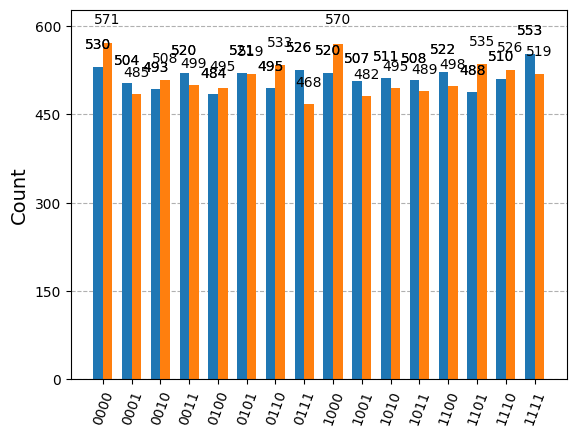

In [38]:
plot_histogram(counts_noise)

We observe that in the presence of noise we get more spurious hits than without noise and that each measured phase points almost equally to a solution.